# 机器学习纳米学位
## 监督学习
## 项目2: 为*CharityML*寻找捐献者

欢迎来到机器学习工程师纳米学位的第二个项目！在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以**'练习'**开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。
>**提示：**Code 和 Markdown 区域可通过**Shift + Enter**快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 开始

在这个项目中，你将使用1994年美国人口普查收集的数据，选用几个监督学习算法以准确地建模被调查者的收入。然后，你将根据初步结果从中选择出最佳的候选算法，并进一步优化该算法以最好地建模这些数据。你的目标是建立一个能够准确地预测被调查者年收入是否超过50000美元的模型。这种类型的任务会出现在那些依赖于捐款而存在的非营利性组织。了解人群的收入情况可以帮助一个非营利性的机构更好地了解他们要多大的捐赠，或是否他们应该接触这些人。虽然我们很难直接从公开的资源中推断出一个人的一般收入阶层，但是我们可以（也正是我们将要做的）从其他的一些公开的可获得的资源中获得一些特征从而推断出该值。

这个项目的数据集来自[UCI机器学习知识库](https://archive.ics.uci.edu/ml/datasets/Census+Income)。这个数据集是由Ron Kohavi和Barry Becker在发表文章_"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_之后捐赠的，你可以在Ron Kohavi提供的[在线版本](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf)中找到这个文章。我们在这里探索的数据集相比于原有的数据集有一些小小的改变，比如说移除了特征`'fnlwgt'` 以及一些遗失的或者是格式不正确的记录。

----
## 探索数据
运行下面的代码单元以载入需要的Python库并导入人口普查数据。注意数据集的最后一列`'income'`将是我们需要预测的列（表示被调查者的年收入会大于或者是最多50,000美元），人口普查数据中的每一列都将是关于被调查者的特征。

In [2]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs

# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### 练习：数据探索
首先我们对数据集进行一个粗略的探索，我们将看看每一个类别里会有多少被调查者？并且告诉我们这些里面多大比例是年收入大于50,000美元的。在下面的代码单元中，你将需要计算以下量：

- 总的记录数量，`'n_records'`
- 年收入大于50,000美元的人数，`'n_greater_50k'`.
- 年收入最多为50,000美元的人数 `'n_at_most_50k'`.
- 年收入大于50,000美元的人所占的比例， `'greater_percent'`.

**提示：** 您可能需要查看上面的生成的表，以了解`'income'`条目的格式是什么样的。 

In [3]:
# TODO：总的记录数
n_records = len(data)
# TODO：被调查者的收入大于$50,000的人数
n_greater_50k = len(data.loc[data["income"]==">50K"])
# TODO：被调查者的收入最多为$50,000的人数
n_at_most_50k = len(data.loc[data["income"]=="<=50K"])
# TODO：被调查者收入大于$50,000所占的比例
greater_percent = float(n_greater_50k)/n_records

# 打印结果
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent*100)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## 准备数据
在数据能够被作为输入提供给机器学习算法之前，它经常需要被清洗，格式化，和重新组织 - 这通常被叫做**预处理**。幸运的是，对于这个数据集，没有我们必须处理的无效或丢失的条目，然而，由于某一些特征存在的特性我们必须进行一定的调整。这个预处理都可以极大地帮助我们提升几乎所有的学习算法的结果和预测能力。

### 转换倾斜的连续特征

一个数据集有时可能包含至少一个靠近某个数字的特征，但有时也会有一些相对来说存在极大值或者极小值的不平凡分布的的特征。算法对这种分布的数据会十分敏感，并且如果这种数据没有能够很好地规一化处理会使得算法表现不佳。在人口普查数据集的两个特征符合这个描述：'`capital-gain'`和`'capital-loss'`。

运行下面的代码单元以创建一个关于这两个特征的条形图。请注意当前的值的范围和它们是如何分布的。

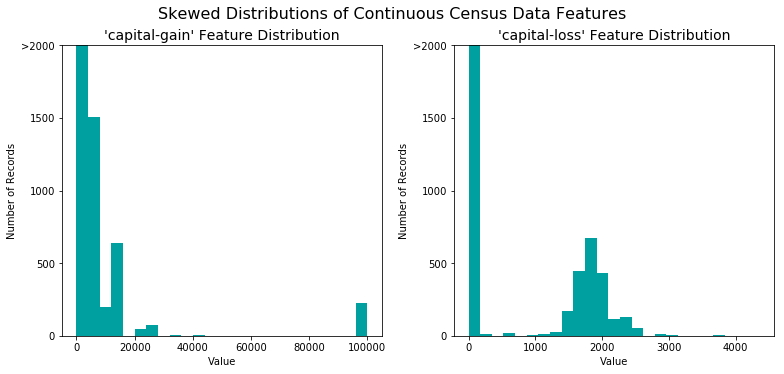

In [4]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# 可视化原来数据的倾斜的连续特征
vs.distribution(data)

对于高度倾斜分布的特征如`'capital-gain'`和`'capital-loss'`，常见的做法是对数据施加一个<a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">对数转换</a>，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。但是在应用这个变换时必须小心：因为0的对数是没有定义的，所以我们必须先将数据处理成一个比0稍微大一点的数以成功完成对数转换。

运行下面的代码单元来执行数据的转换和可视化结果。再次，注意值的范围和它们是如何分布的。

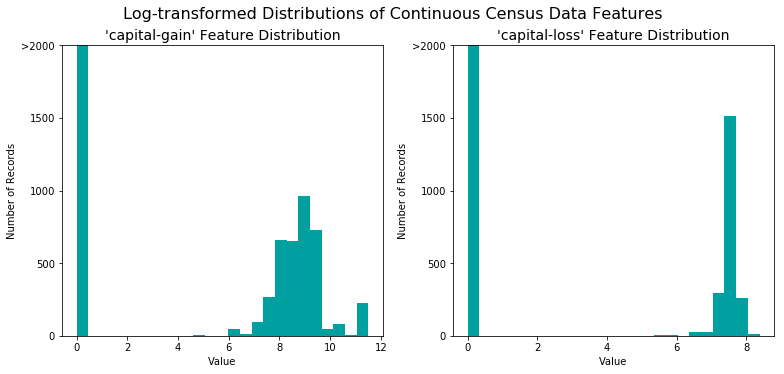

In [5]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化经过log之后的数据分布
vs.distribution(features_raw, transformed = True)

### 规一化数字特征
除了对于高度倾斜的特征施加转换，对数值特征施加一些形式的缩放通常会是一个好的习惯。在数据上面施加一个缩放并不会改变数据分布的形式（比如上面说的'capital-gain' or 'capital-loss'）；但是，规一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。注意一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了，就像下面的例子展示的。

运行下面的代码单元来规一化每一个数字特征。我们将使用[`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)来完成这个任务。

In [6]:
# 导入sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### 练习：数据预处理

从上面的**数据探索**中的表中，我们可以看到有几个属性的每一条记录都是非数字的。通常情况下，学习算法期望输入是数字的，这要求非数字的特征（称为类别变量）被转换。转换类别变量的一种流行的方法是使用**独热编码**方案。独热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设`someFeature`有三个可能的取值`A`，`B`或者`C`，。我们将把这个特征编码成`someFeature_A`, `someFeature_B`和`someFeature_C`.

|   | 一些特征 |                    | 特征_A | 特征_B | 特征_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> 独热编码 ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

此外，对于非数字的特征，我们需要将非数字的标签`'income'`转换成数值以保证学习算法能够正常工作。因为这个标签只有两种可能的类别（"<=50K"和">50K"），我们不必要使用独热编码，可以直接将他们编码分别成两个类`0`和`1`，在下面的代码单元中你将实现以下功能：
 - 使用[`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies)对`'features_raw'`数据来施加一个独热编码。
 - 将目标标签`'income_raw'`转换成数字项。
   - 将"<=50K"转换成`0`；将">50K"转换成`1`。

In [7]:
# TODO：使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)

# TODO：将'income_raw'编码成数字值
income = pd.get_dummies(income_raw)['>50K']
# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# 移除下面一行的注释以观察编码的特征名字
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### 混洗和切分数据
现在所有的 _类别变量_ 已被转换成数值特征，而且所有的数值特征已被规一化。和我们一般情况下做的一样，我们现在将数据（包括特征和它们的标签）切分成训练和测试集。其中80%的数据将用于训练和20%的数据用于测试。

运行下面的代码单元来完成切分。

In [8]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)
# 显示切分的结果
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## 评价模型性能
在这一部分中，我们将尝试四种不同的算法，并确定哪一个能够最好地建模数据。这里面的三个将是你选择的监督学习器，而第四种算法被称为一个*朴素的预测器*。


### 评价方法和朴素的预测器
*CharityML*通过他们的研究人员知道被调查者的年收入大于\$50,000最有可能向他们捐款。因为这个原因*CharityML*对于准确预测谁能够获得\$50,000以上收入尤其有兴趣。这样看起来使用**准确率**作为评价模型的标准是合适的。另外，把*没有*收入大于\$50,000的人识别成年收入大于\$50,000对于*CharityML*来说是有害的，因为他想要找到的是有意愿捐款的用户。这样，我们期望的模型具有准确预测那些能够年收入大于\$50,000的能力比模型去**查全**这些被调查者*更重要*。我们能够使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当$\beta = 0.5$的时候更多的强调查准率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

通过查看不同类别的数据分布（那些最多赚\$50,000和那些能够赚更多的），我们能发现：很明显的是很多的被调查者年收入没有超过\$50,000。这点会显著地影响**准确率**，因为我们可以简单地预测说*“这个人的收入没有超过\$50,000”*，这样我们甚至不用看数据就能做到我们的预测在一般情况下是正确的！做这样一个预测被称作是**朴素的**，因为我们没有任何信息去证实这种说法。通常考虑对你的数据使用一个*朴素的预测器*是十分重要的，这样能够帮助我们建立一个模型的表现是否好的基准。那有人说，使用这样一个预测是没有意义的：如果我们预测所有人的收入都低于\$50,000，那么*CharityML*就不会有人捐款了。

### 问题 1 - 朴素预测器的性能
*如果我们选择一个无论什么情况都预测被调查者年收入大于\$50,000的模型，那么这个模型在这个数据集上的准确率和F-score是多少？*  
**注意：** 你必须使用下面的代码单元将你的计算结果赋值给`'accuracy'` 和 `'fscore'`，这些值会在后面被使用，请注意这里不能使用scikit-learn，你需要根据公式自己实现相关计算。

In [9]:
# TODO： 计算准确率
accuracy = (income==income.replace(0,1)).mean()
# TODO： 使用上面的公式，并设置beta=0.5计算F-score
precision=float(n_greater_50k)/n_records
recall=1
fscore = (1+0.5**2)*precision*recall/(0.5**2*precision+recall)

# 打印结果
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### 监督学习模型
**下面的监督学习模型是现在在** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **中你能够选择的模型**
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (KNeighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归


### 问题 2 - 模型应用

列出从上面的监督学习模型中选择的三个适合我们这个问题的模型，你将在人口普查数据上测试这每个算法。对于你选择的每一个算法：

- *描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）*
- *这个模型的优势是什么？他什么情况下表现最好？*
- *这个模型的缺点是什么？什么条件下它表现很差？*
- *根据我们当前数据集的特点，为什么这个模型适合这个问题。*

**回答：**Gradient Boosting，Logistic回归，随机梯度下降分类器
    
Gradient Boosting：
- 学习排名（雅虎) 。 
- 高维特征选择，预测性强，对异常值容忍度高，二分类最好。
- 每次对目标值与预测值残差进行拟合，不能并行，多分类表现不太好。
- 高维特征，分类问题。

Logistic回归：
- 冠心病危险因素（中国循证医学杂志）。
- 模型清晰，直接、快速，自变量和Logistic概率是线性关系表现最好。
- 要求严格的假设，需要处理异常值，自变量和Logistic概率不是线性关系表现最差。
- 当前数据集处理是二分类问题 。

随机梯度下降分类器：
- 图片识别（TensorFlow）。
- 高效，容易实现，进行严格特征归一化效果最好。
- 需要许多超参数，特征归一化不足则很差。
- 当前数据集样本量多，多变量，且是分类问题，随机梯度下降很适合处理这类问题。

### 练习 - 创建一个训练和预测的流水线
为了正确评估你选择的每一个模型的性能，创建一个能够帮助你快速有效地使用不同大小的训练集并在测试集上做预测的训练和测试的流水线是十分重要的。
你在这里实现的功能将会在接下来的部分中被用到。在下面的代码单元中，你将实现以下功能：

 - 从[`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)中导入`fbeta_score`和`accuracy_score`。
 - 用样例训练集拟合学习器，并记录训练时间。
 - 用学习器来对训练集进行预测并记录预测时间。
 - 在最前面的300个*训练数据*上做预测。
 - 计算训练数据和测试数据的准确率。
 - 计算训练数据和测试数据的F-score。

In [10]:
# TODO：从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO：使用sample_size大小的训练数据来拟合学习器
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # 获得程序开始时间
    #print (y_train['>50K'])[0:3]
    learner = learner.fit(X_train[0:sample_size],(y_train)[0:sample_size])
    
    end = time() # 获得程序结束时间
    
    # TODO：计算训练时间
    results['train_time'] = end-start
    
    # TODO: 得到在测试集上的预测值
    #       然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # 获得程序结束时间
    
    # TODO：计算预测用时
    results['pred_time'] = end-start
            
    # TODO：计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[0:300],predictions_train)
        
    # TODO：计算在测试集上的准确率['>50K']
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO：计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[0:300],predictions_train, beta=0.5)
        
    # TODO：计算测试集上的F-score
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # 成功
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # 返回结果
    return results

### 练习：初始模型的评估
在下面的代码单元中，您将需要实现以下功能：             
- 导入你在前面讨论的三个监督学习模型。             
- 初始化三个模型并存储在`'clf_A'`，`'clf_B'`和`'clf_C'`中。         
  - 如果可能对每一个模型都设置一个`random_state`。       
  - **注意：**这里先使用每一个模型的默认参数，在接下来的部分中你将需要对某一个模型的参数进行调整。             
- 计算记录的数目等于1%，10%，和100%的训练数据，并将这些值存储在`'samples'`中             

**注意：**取决于你选择的算法，下面实现的代码可能需要一些时间来运行！

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.


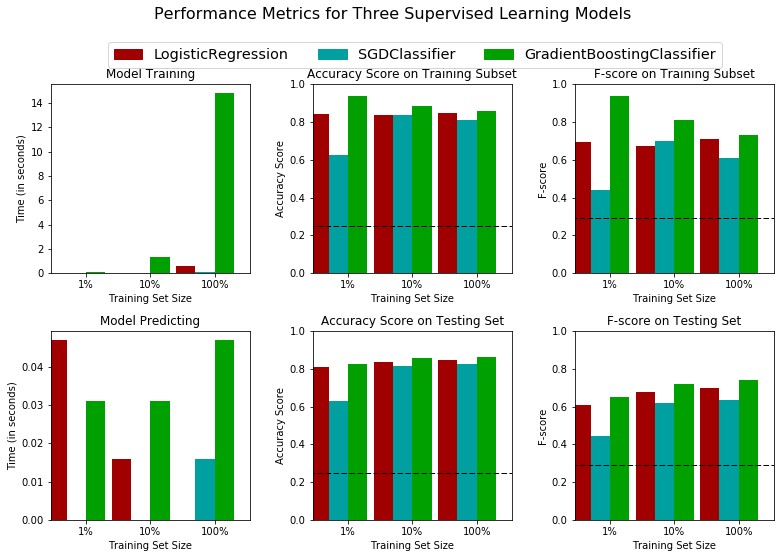

In [11]:
# TODO：从sklearn中导入三个监督学习模型
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
# TODO：初始化三个模型
clf_A = GradientBoostingClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0)
clf_C = SGDClassifier(random_state=0)

# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0]*0.01)
samples_10 = int(X_train.shape[0]*0.1)
samples_100 = X_train.shape[0]

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

----
## 提高效果

在这最后一节中，您将从三个有监督的学习模型中选择*最好的*模型来使用学生数据。你将在整个训练集（`X_train`和`y_train`）上通过使用网格搜索优化至少调节一个参数以获得一个比没有调节之前更好的F-score。

### 问题 3 - 选择最佳的模型

*基于你前面做的评价，用一到两段向*CharityML*解释这三个模型中哪一个对于判断被调查者的年收入大于\$50,000是最合适的。*             
**提示：**你的答案应该包括关于评价指标，预测/训练时间，以及该算法是否适合这里的数据的讨论。

**回答：**GradientBoosting，相比较而言，虽然训练时间和预测时间比其他模型长，但准确率和F-score最高的。

### 问题 4 - 用通俗的话解释模型

*用一到两段话，向*CharityML*用外行也听得懂的话来解释最终模型是如何工作的。你需要解释所选模型的主要特点。例如，这个模型是怎样被训练的，它又是如何做出预测的。避免使用高级的数学或技术术语，不要使用公式或特定的算法名词。*

**回答： **
- 在GradientBoosting中，采取分层学习的方法，通过M个步骤来得到最终模型F，在第m步学习一个较弱的$F_ {m}$模型，在m+1步不直接优化$F_ {m+1}$，而是用一个基本模型h(x)使得其学习目标值y-$F_ {m}$,这样就会使m+1步的模型预测值$F_ {m+1}$=$F_ {m}$+h(x)更接近于真实值y。
- 通过上面训练的模型F对测试集进行预测。

### 练习：模型调优
调节选择的模型的参数。使用网格搜索（GridSearchCV）来至少调整模型的重要参数（至少调整一个），这个参数至少需给出并尝试3个不同的值。你要使用整个训练集来完成这个过程。在接下来的代码单元中，你需要实现以下功能：

- 导入[`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)和[`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- 初始化你选择的分类器，并将其存储在`clf`中。
 - 如果能够设置的话，设置`random_state`。
- 创建一个对于这个模型你希望调整参数的字典。
 - 例如: parameters = {'parameter' : [list of values]}。
 - **注意：** 如果你的学习器（learner）有 `max_features` 参数，请不要调节它！
- 使用`make_scorer`来创建一个`fbeta_score`评分对象（设置$\beta = 0.5$）。
- 在分类器clf上用'scorer'作为评价函数运行网格搜索，并将结果存储在grid_obj中。
- 用训练集（X_train, y_train）训练grid search object,并将结果存储在`grid_fit`中。

**注意：** 取决于你选择的参数列表，下面实现的代码可能需要花一些时间运行！

In [12]:
# TODO：导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
# TODO：初始化分类器
clf = GradientBoostingClassifier(random_state=0)
# TODO：创建你希望调节的参数列表
#parameters = {'max_depth':range(5,16,2)}
parameters = {'n_estimators' : range(50, 550, 50), 'learning_rate' :np.linspace(0.01, 0.2, 20) }
# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数.
#grid_obj = GridSearchCV(clf,parameters,scorer,cv=10) 
rdm_obj = RandomizedSearchCV(clf,parameters,scoring=scorer, n_iter = 6)
# TODO：用训练数据拟合网格搜索对象并找到最佳参数
#grid_fit=grid_obj.fit(X_train, y_train)
rdm_obj.fit(X_train, y_train)
# 得到estimator
#best_clf = grid_obj.best_estimator_
best_clf = rdm_obj.best_estimator_
# 使用没有调优的模型做预测
#predictions = (clf.fit(X_train, y_train)).predict(X_test)
#best_predictions = best_clf.predict(X_test)
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
# 汇报调参前和调参后的分数
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8722
Final F-score on the testing data: 0.7557


### 问题 5 - 最终模型评估

_你的最优模型在测试数据上的准确率和F-score是多少？这些分数比没有优化的模型好还是差？你优化的结果相比于你在**问题 1**中得到的朴素预测器怎么样？_  
**注意：**请在下面的表格中填写你的结果，然后在答案框中提供讨论。

#### 结果:

|     评价指标     | 基准预测器 | 未优化的模型 | 优化的模型 |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| 准确率 | 0.2478                    |      0.8630           |      0.8722          |
| F-score|   0.2917                 |        0.7395          |   0.7557      |


**回答：**0.8722,0.7557.好，相比于在问题 1中得到的朴素预测器好很多。

----
## 特征的重要性

在数据上（比如我们这里使用的人口普查的数据）使用监督学习算法的一个重要的任务是决定哪些特征能够提供最强的预测能力。通过专注于一些少量的有效特征和标签之间的关系，我们能够更加简单地理解这些现象，这在很多情况下都是十分有用的。在这个项目的情境下这表示我们希望选择一小部分特征，这些特征能够在预测被调查者是否年收入大于\$50,000这个问题上有很强的预测能力。

选择一个有`feature_importance_`属性（这是一个根据这个选择的分类器来对特征的重要性进行排序的函数）的scikit学习分类器（例如，AdaBoost，随机森林）。在下一个Python代码单元中用这个分类器拟合训练集数据并使用这个属性来决定这个人口普查数据中最重要的5个特征。

### 问题 6 - 观察特征相关性

当**探索数据**的时候，它显示在这个人口普查数据集中每一条记录我们有十三个可用的特征。             
_在这十三个记录中，你认为哪五个特征对于预测是最重要的，你会怎样对他们排序？理由是什么？_

**回答：**occupation，education_level，workclass，race，sex.从事工作不同薪水是很大区别，受教育水平限制了你从事的工作类型，工作类别也很能看出薪水区别，白种人及亚裔相对比黑人工资高，男性相对比女性高。

### 练习 - 提取特征重要性

选择一个`scikit-learn`中有`feature_importance_`属性的监督学习分类器，这个属性是一个在做预测的时候根据所选择的算法来对特征重要性进行排序的功能。

在下面的代码单元中，你将要实现以下功能：
 - 如果这个模型和你前面使用的三个模型不一样的话从sklearn中导入一个监督学习模型。
 - 在整个训练集上训练一个监督学习模型。
 - 使用模型中的`'.feature_importances_'`提取特征的重要性。

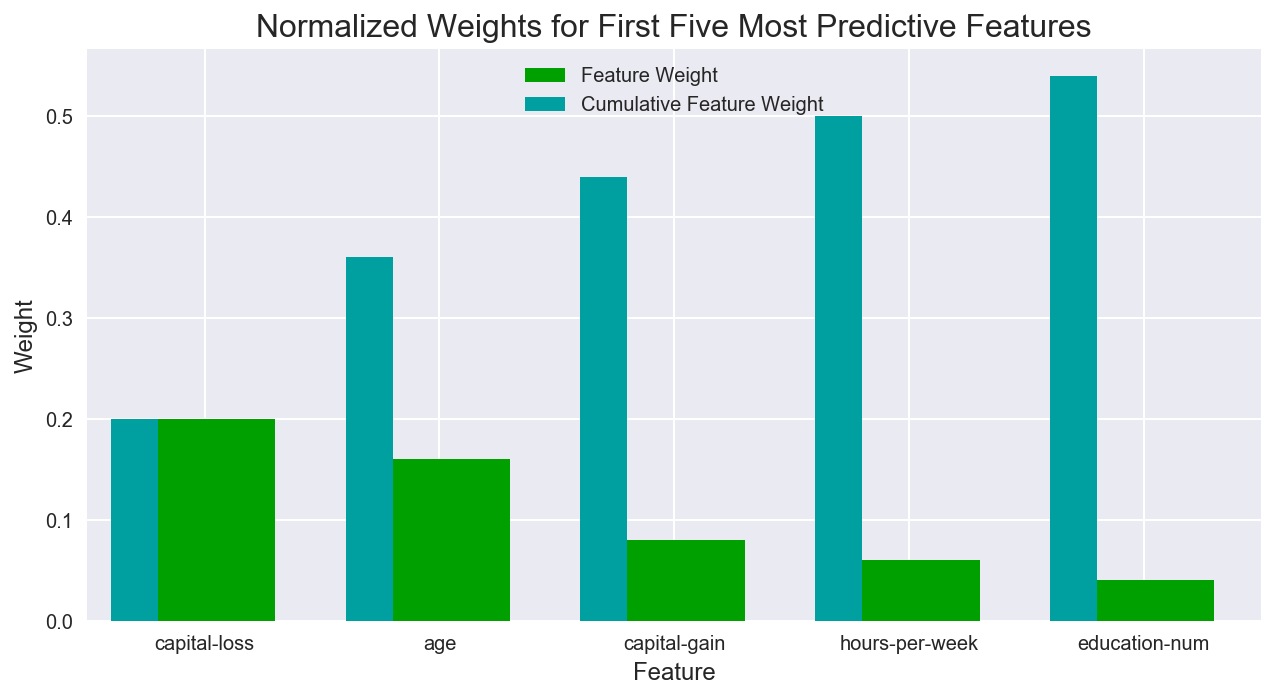

In [18]:
# TODO：导入一个有'feature_importances_'的监督学习模型
from sklearn.ensemble import AdaBoostClassifier
# TODO：在训练集上训练一个监督学习模型
model = AdaBoostClassifier().fit(X_train, y_train)

# TODO： 提取特征重要性
importances = model.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)

### 问题 7 - 提取特征重要性
观察上面创建的展示五个用于预测被调查者年收入是否大于\$50,000最相关的特征的可视化图像。
_这五个特征和你在**问题 6**中讨论的特征比较怎么样？如果说你的答案和这里的相近，那么这个可视化怎样佐证了你的想法？如果你的选择不相近，那么为什么你觉得这些特征更加相关？_

**回答：**不相近，从下面的图中可以看出大部分大于50K的人的education-num是比小于等于50K的人的education-num大；大部分大于50K的人的hours-per-week是比小于等于50K的人的hours-per-week要长；大于50K的人的age的中位数和下四分位是比小于等于50K的人的age的中位数和下四分位大；大于50K的人的capital-gain和小于等于50K的人的capital-gain大部分为0，而大于50K的人的capital-gain的异常值的中位数比小于等于50K的人的capital-gain异常值要大；大于50K的人的capital-loss和小于等于50K的人的capital-loss大部分为0，而大于50K的人的capital-loss的异常值的中位数比小于等于50K的人的capital-loss异常值要大。
- 收入大于50K相比收入小于等于50K，education-num更大，hours-per-week更长，capital-gain更大，age更大，capital-loss更大。

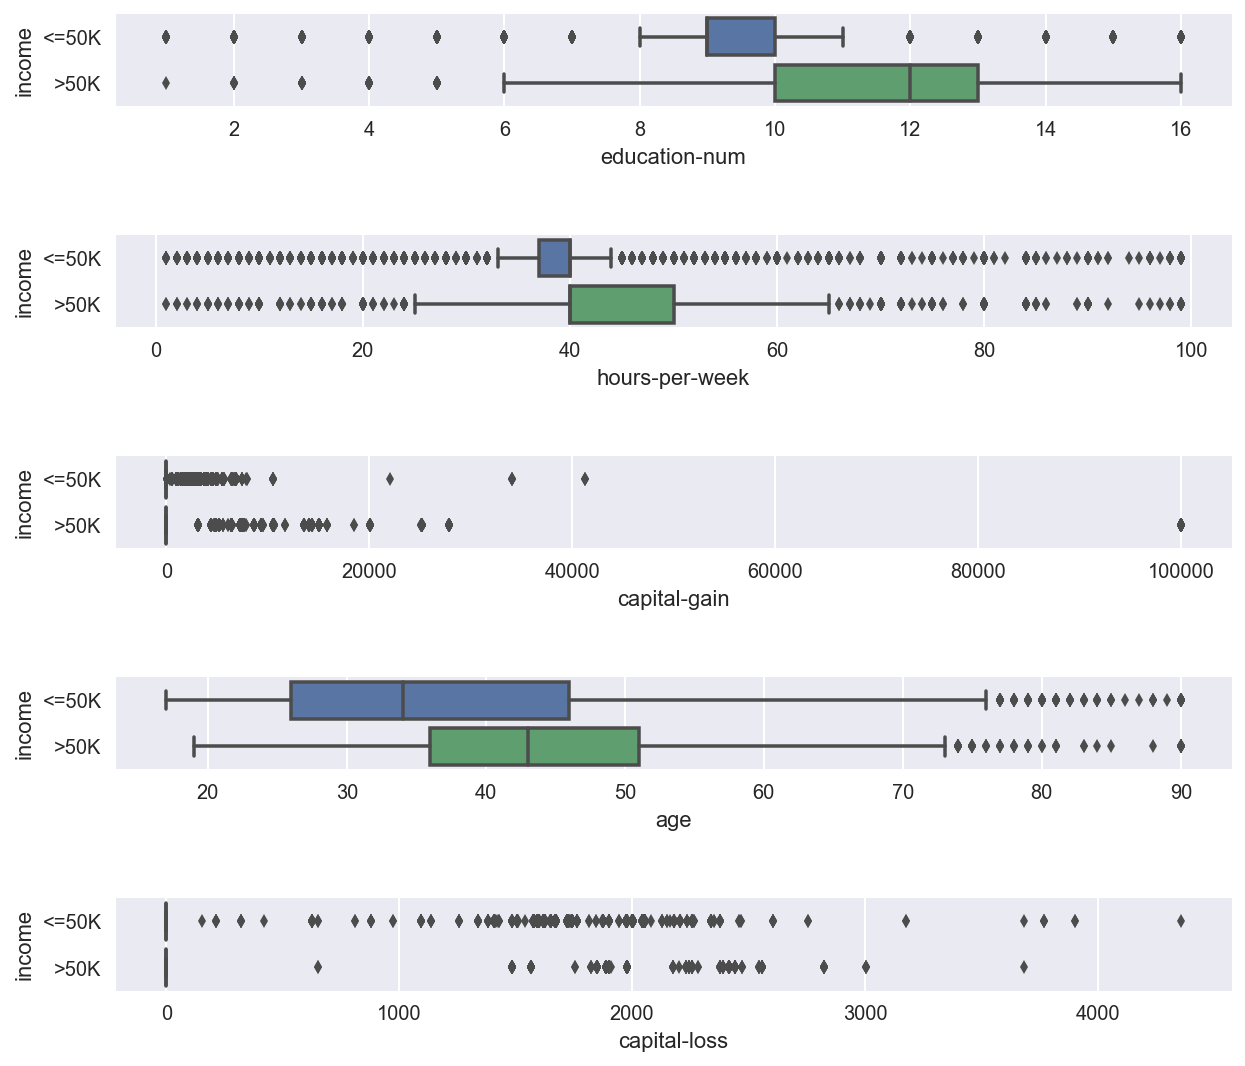

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(10,1,1)
ax2 = fig.add_subplot(10,1,3)
ax3 = fig.add_subplot(10,1,5)
ax4 = fig.add_subplot(10,1,7)
ax5 = fig.add_subplot(10,1,9)
%config InlineBackend.figure_format = 'retina'
sns.boxplot(x='education-num', y='income', data=data,ax=ax1)
sns.boxplot(x='hours-per-week', y='income', data=data,ax=ax2)
sns.boxplot(x='capital-gain', y='income', data=data,ax=ax3)
sns.boxplot(x='age', y='income', data=data,ax=ax4)
sns.boxplot(x='capital-loss', y='income', data=data,ax=ax5)

### 特征选择

如果我们只是用可用特征的一个子集的话模型表现会怎么样？通过使用更少的特征来训练，在评价指标的角度来看我们的期望是训练和预测的时间会更少。从上面的可视化来看，我们可以看到前五个最重要的特征贡献了数据中**所有**特征中超过一半的重要性。这提示我们可以尝试去*减小特征空间*，并简化模型需要学习的信息。下面代码单元将使用你前面发现的优化模型，并*只使用五个最重要的特征*在相同的训练集上训练模型。

In [29]:
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]
# 在前面的网格搜索的基础上训练一个“最好的”模型
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# 做一个新的预测
reduced_predictions = clf.predict(X_test_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8348
F-score on testing data: 0.6666

Final Model trained on reduced data
------
Accuracy on testing data: 0.7791
F-score on testing data: 0.3755


### 问题 8 - 特征选择的影响

*最终模型在只是用五个特征的数据上和使用所有的特征数据上的F-score和准确率相比怎么样？*  
*如果训练时间是一个要考虑的因素，你会考虑使用部分特征的数据作为你的训练集吗？*

**回答：**只用五个特征的数据的F-score和准确率比使用所有的特征数据的F-score和准确率差，不会，会用更好的模型。

> **注意：** 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。